In [1]:
# code to import zipped lhe file and convert to root file

import numpy as np
import gzip
import ROOT
import array

#file path
lhe_file = "/Users/johno.aremu/Documents/pp_to_4l/unweighted_events.lhe.gz"
root_file_path = "events.root"

#prepare root file and tree
root_file = ROOT.TFile(root_file_path, "RECREATE")
tree = ROOT.TTree("Events", "pp --> ZZ --> 4l events")

#arrays for 4 leptons (px, py, pz, E)
px = array.array('f', [0]*4)
py = array.array('f', [0]*4)
pz = array.array('f', [0]*4)
E = array.array('f', [0]*4)

#create branches in the tree
for i in range(4):
    tree.Branch(f"px_{i+1}", px, f"px_{i+1}/F")
    tree.Branch(f"py_{i+1}", py, f"py_{i+1}/F")
    tree.Branch(f"pz_{i+1}", pz, f"pz_{i+1}/F")
    tree.Branch(f"E_{i+1}", E, f"E_{i+1}/F")

#parse the LHE file and fill the tree
with gzip.open(lhe_file, 'rt') as f:
    lines = f.readlines()
event_count = 0
i = 0
while i < len(lines):
    line = lines[i].strip()
    if line == "<event>":
        event_count += 1
        i += 1
        event_info = lines[i].strip().split()
        num_particles = int(event_info[0])
        lepton_index = 0
        for j in range(num_particles):
            i += 1
            particle_info = lines[i].strip().split()
            pdg_id = int(particle_info[0])
            status = int(particle_info[1])
            if abs(pdg_id) in [11, 13] and status == 1:  # electron or muon and final state
                if lepton_index < 4:
                    px[lepton_index] = float(particle_info[6])
                    py[lepton_index] = float(particle_info[7])
                    pz[lepton_index] = float(particle_info[8])
                    E[lepton_index] = float(particle_info[9])
                    lepton_index += 1
        tree.Fill()
    i += 1
print(f"Total events processed: {event_count}")

#write and close the root file
root_file.Write()
root_file.Close()

#print(f"Root file '{root_file_path}' created with {event_count} events.")
print(f"Root file '{root_file_path}' created with {event_count} events.")


Total events processed: 10000
Root file 'events.root' created with 10000 events.


In [2]:
# file path

lhe_file = "/Users/johno.aremu/Documents/pp_to_4l/unweighted_events.lhe.gz"
root_file_path = "events2.root"

#prepare root file and tree
root_file_update = ROOT.TFile(root_file_path, "RECREATE")
tree = ROOT.TTree("Events", "pp --> ZZ --> 4l events")

#arrays for each event which has 4 leptons output for all the data entries that can be used as vector entries
pid_vec = ROOT.std.vector('int')()
px_vec = ROOT.std.vector('float')()
py_vec = ROOT.std.vector('float')()
pz_vec = ROOT.std.vector('float')()
E_vec = ROOT.std.vector('float')()
char_vec = ROOT.std.vector('int')()


tree.Branch("pid", pid_vec)
tree.Branch("px", px_vec)
tree.Branch("py", py_vec)
tree.Branch("pz", pz_vec)
tree.Branch("E", E_vec)
tree.Branch("charge", char_vec)

#get charge and pid arrays
def get_charge_and_pid(pdg_id):
    if pdg_id > 0:
        return -1, pdg_id  # positron or antimuon
    else:
        return 1, pdg_id   # electron or muon

#parse the LHE file and fill the tree
with gzip.open(lhe_file, 'rt') as f:
    lines = f.readlines()
event_count = 0
i = 0
while i < len(lines):
    line = lines[i].strip()
    if line == "<event>":
        event_count += 1
        i += 1
        event_info = lines[i].strip().split()
        num_particles = int(event_info[0])
        
        # Clear vectors for the new event
        pid_vec.clear()
        px_vec.clear()
        py_vec.clear()
        pz_vec.clear()
        E_vec.clear()
        char_vec.clear()
        
        # Loop over particles in the event and fill vectors
        for j in range(num_particles):
            i += 1
            particle_info = lines[i].strip().split()
            pdg_id = int(particle_info[0])
            status = int(particle_info[1])
            if abs(pdg_id) in [11, 13] and status == 1:  # electron or muon and final state
                charge, pid = get_charge_and_pid(pdg_id)
                pid_vec.push_back(pid)
                px_vec.push_back(float(particle_info[6]))
                py_vec.push_back(float(particle_info[7]))
                pz_vec.push_back(float(particle_info[8]))
                E_vec.push_back(float(particle_info[9]))
                char_vec.push_back(charge)
        tree.Fill()
    i += 1
print(f"Total events processed: {event_count}")

#write and close the root file
root_file_update.Write()
root_file_update.Close()

Total events processed: 10000


In [3]:
import numpy as np
import gzip
import ROOT
import array
import math

# File paths
lhe_file = "/Users/johno.aremu/Documents/pp_to_4l/unweighted_events.lhe.gz"
root_file_path = "events3.root"

# Prepare ROOT file and tree
root_file = ROOT.TFile(root_file_path, "RECREATE")
tree = ROOT.TTree("Events", "pp --> ZZ --> 4l events")

# Branch variables
run = array.array('i', [1])
luminosityBlock = array.array('I', [1])
event_number = array.array('L', [0])

# Muon variables
nMuon = array.array('I', [0])
Muon_pt = ROOT.std.vector('float')()
Muon_eta = ROOT.std.vector('float')()
Muon_phi = ROOT.std.vector('float')()
Muon_mass = ROOT.std.vector('float')()
Muon_charge = ROOT.std.vector('int')()

# Electron variables
nElectron = array.array('I', [0])
Electron_pt = ROOT.std.vector('float')()
Electron_eta = ROOT.std.vector('float')()
Electron_phi = ROOT.std.vector('float')()
Electron_mass = ROOT.std.vector('float')()
Electron_charge = ROOT.std.vector('int')()

# MET variables
MET_pt = array.array('f', [0.])
MET_phi = array.array('f', [0.])

# Create branches
tree.Branch("run", run, "run/I") 
tree.Branch("luminosityBlock", luminosityBlock, "luminosityBlock/i")
tree.Branch("event", event_number, "event/l")

tree.Branch("nMuon", nMuon, "nMuon/i")
tree.Branch("Muon_pt", Muon_pt)
tree.Branch("Muon_eta", Muon_eta)
tree.Branch("Muon_phi", Muon_phi)
tree.Branch("Muon_mass", Muon_mass)
tree.Branch("Muon_charge", Muon_charge)

tree.Branch("nElectron", nElectron, "nElectron/i")
tree.Branch("Electron_pt", Electron_pt)
tree.Branch("Electron_eta", Electron_eta)
tree.Branch("Electron_phi", Electron_phi)
tree.Branch("Electron_mass", Electron_mass)
tree.Branch("Electron_charge", Electron_charge)

tree.Branch("MET_pt", MET_pt, "MET_pt/F")
tree.Branch("MET_phi", MET_phi, "MET_phi/F")

# Utility functions
def compute_pt(px, py):
    return np.sqrt(px**2 + py**2)

def compute_eta(px, py, pz):
    p = np.sqrt(px**2 + py**2 + pz**2)
    if p == abs(pz):
        return 0.0  # avoid divide by zero or inf
    return 0.5 * np.log((p + pz) / (p - pz))

def compute_phi(px, py):
    return np.arctan2(py, px)

# Read and parse LHE file
with gzip.open(lhe_file, 'rt') as f:
    in_event = False
    event_lines = []
    event_id = 0

    for line in f:
        line = line.strip()

        if line == "<event>":
            in_event = True
            event_lines = []
        elif line == "</event>":
            in_event = False
            event_id += 1
            event_number[0] = event_id

            # Reset all vectors
            Muon_pt.clear()
            Muon_eta.clear()
            Muon_phi.clear()
            Muon_mass.clear()
            Muon_charge.clear()
            Electron_pt.clear()
            Electron_eta.clear()
            Electron_phi.clear()
            Electron_mass.clear()
            Electron_charge.clear()

            # MET variables
            met_px = 0.0
            met_py = 0.0

            # Parse event lines
            particles = event_lines[1:]  # skip header line
            for p in particles:
                tokens = p.strip().split()
                if len(tokens) < 10:
                    continue

                pdg_id = int(tokens[0])
                status = int(tokens[1])
                mother1 = int(tokens[2])
                mother2 = int(tokens[3])
                color1 = int(tokens[4])
                color2 = int(tokens[5])
                px = float(tokens[6])
                py = float(tokens[7])
                pz = float(tokens[8])
                E  = float(tokens[9])
                mass = float(tokens[10])
                charge = 0

                # Determine charge
                if pdg_id in [11, 13]: charge = -1
                elif pdg_id in [-11, -13]: charge = 1

                pt = compute_pt(px, py)
                phi = compute_phi(px, py)
                eta = compute_eta(px, py, pz)

                if abs(pdg_id) == 11:  # Electron
                    Electron_pt.push_back(pt)
                    Electron_eta.push_back(eta)
                    Electron_phi.push_back(phi)
                    Electron_mass.push_back(mass)
                    Electron_charge.push_back(charge)

                elif abs(pdg_id) == 13:  # Muon
                    Muon_pt.push_back(pt)
                    Muon_eta.push_back(eta)
                    Muon_phi.push_back(phi)
                    Muon_mass.push_back(mass)
                    Muon_charge.push_back(charge)

                elif abs(pdg_id) in [12, 14]:  # Neutrino (only use for MET)
                    met_px += px
                    met_py += py

            # Finalize counts
            nMuon[0] = Muon_pt.size()
            nElectron[0] = Electron_pt.size()

            # MET
            MET_pt[0] = np.sqrt(met_px**2 + met_py**2)
            MET_phi[0] = np.arctan2(met_py, met_px)

            # Fill tree
            tree.Fill()

        elif in_event:
            event_lines.append(line)

# Write and close
root_file.Write()
root_file.Close()

print(f"Finished writing ROOT file: {root_file_path}")
print(f"Total events processed: {event_id}")


Finished writing ROOT file: events3.root
Total events processed: 10000


In [4]:
import uproot
file = uproot.open("events2.root")
tree = file["Events"]

#check the branches in the tree
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
pid                  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
E                    | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
charge               | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...


In [5]:
file1 = uproot.open("events.root")
tree1 = file1["Events"]

#check the branches in the tree
tree1.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
px_1                 | float                    | AsDtype('>f4')
py_1                 | float                    | AsDtype('>f4')
pz_1                 | float                    | AsDtype('>f4')
E_1                  | float                    | AsDtype('>f4')
px_2                 | float                    | AsDtype('>f4')
py_2                 | float                    | AsDtype('>f4')
pz_2                 | float                    | AsDtype('>f4')
E_2                  | float                    | AsDtype('>f4')
px_3                 | float                    | AsDtype('>f4')
py_3                 | float                    | AsDtype('>f4')
pz_3                 | float                    | AsDtype('>f4')
E_3                  | float                    | AsDtype('>f4')
px_4                 | float                    | AsDtype(

In [6]:
file2 = uproot.open("events3.root")
tree2 = file2["Events"]

#check the branches in the tree
tree2.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_eta             | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_phi             | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_mass            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_charge          | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
nElectron            | uint32_t                 | AsDtype('>u4')
Electron_pt          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Electron_eta         | std:

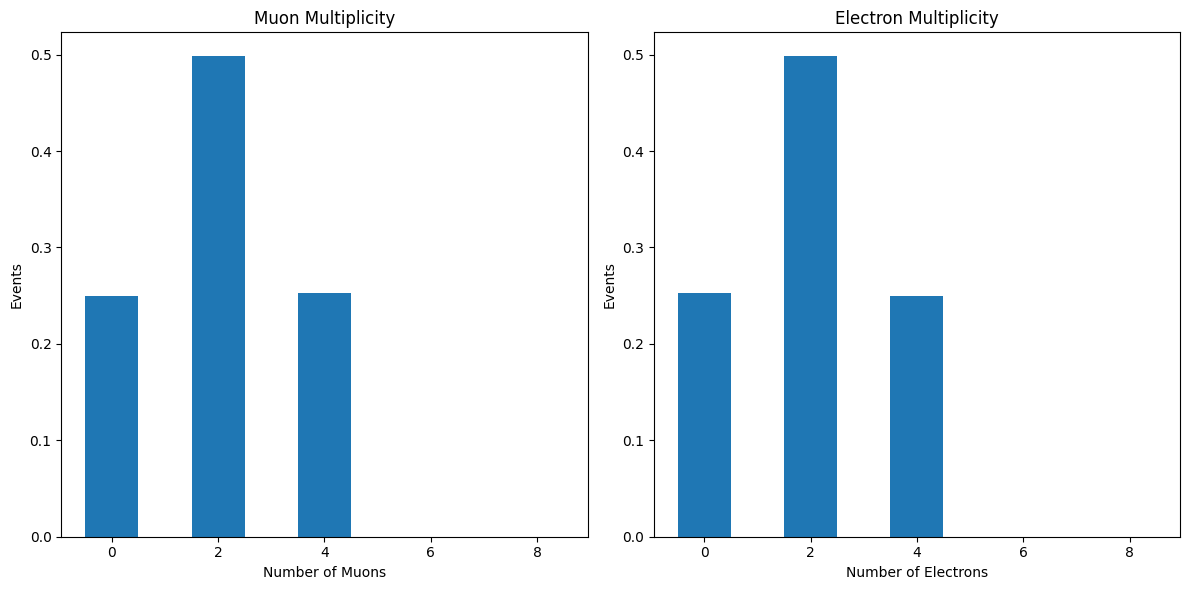

In [7]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import hist

events = tree2.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge"])
elec_events = tree2.arrays(["Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", "Electron_charge"])

muons = ak.zip({    
"pt": events.Muon_pt,    
"eta": events.Muon_eta,    
"phi": events.Muon_phi,    
"mass": events.Muon_mass,       
"charge": events.Muon_charge
}, with_name="Momentum4D")

electrons = ak.zip({    
"pt": elec_events.Electron_pt,    
"eta": elec_events.Electron_eta,    
"phi": elec_events.Electron_phi,    
"mass": elec_events.Electron_mass,    
"charge": elec_events.Electron_charge
}, with_name="Momentum4D")

#sanity check: plot nElectron and nMuon distributions using hist
import hist
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Muon Multiplicity")
plt.xlabel("Number of Muons")
plt.ylabel("Events")
plt.hist(ak.num(muons), bins=np.arange(0, 10)-0.5, density=True)

plt.subplot(1, 2, 2)
plt.title("Electron Multiplicity")
plt.xlabel("Number of Electrons")
plt.ylabel("Events")
plt.hist(ak.num(electrons), bins=np.arange(0, 10)-0.5, density=True)

plt.tight_layout()
plt.show()


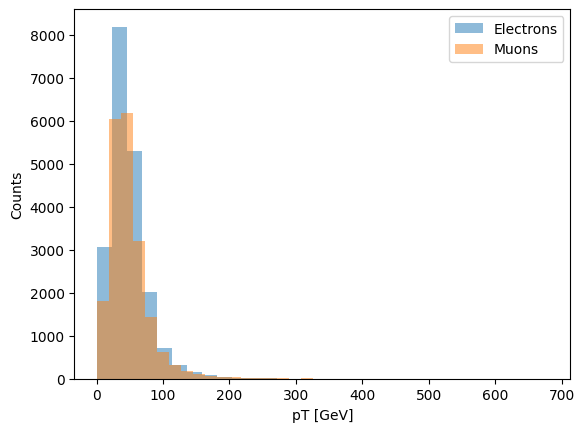

In [8]:
# Plot pT distributions for electrons and muons
# Use tree2 and awkward arrays to get pT values
electron_pts = ak.flatten(elec_events.Electron_pt)
muon_pts = ak.flatten(events.Muon_pt)

plt.hist(electron_pts, bins=30, alpha=0.5, label="Electrons")
plt.hist(muon_pts, bins=30, alpha=0.5, label="Muons")
plt.xlabel("pT [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()

/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.


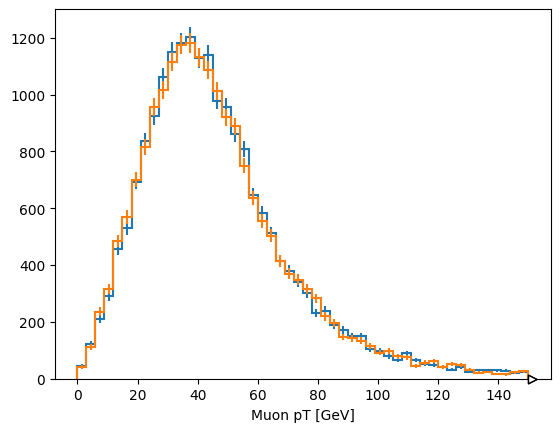

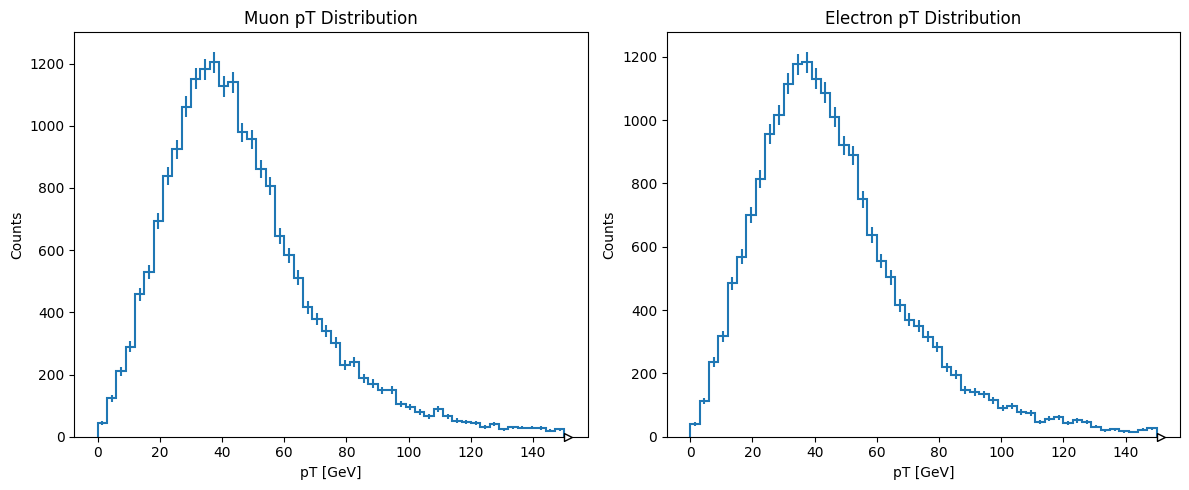

In [9]:
# Plot pT distributions using hist
h_mu_pt = hist.Hist.new.Regular(50, 0, 150, name="Muon pT [GeV]").Double()
h_mu_pt.fill(ak.flatten(muons.pt))
h_mu_pt.plot();

h_elec_pt = hist.Hist.new.Regular(50, 0, 150, name="Electron pT [GeV]").Double()
h_elec_pt.fill(ak.flatten(electrons.pt))
h_elec_pt.plot();  

#plot mupt and elecpt separately   
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
h_mu_pt.plot()
plt.title("Muon pT Distribution")
plt.xlabel("pT [GeV]")
plt.ylabel("Counts")
plt.subplot(1, 2, 2)
h_elec_pt.plot()
plt.title("Electron pT Distribution")
plt.xlabel("pT [GeV]")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

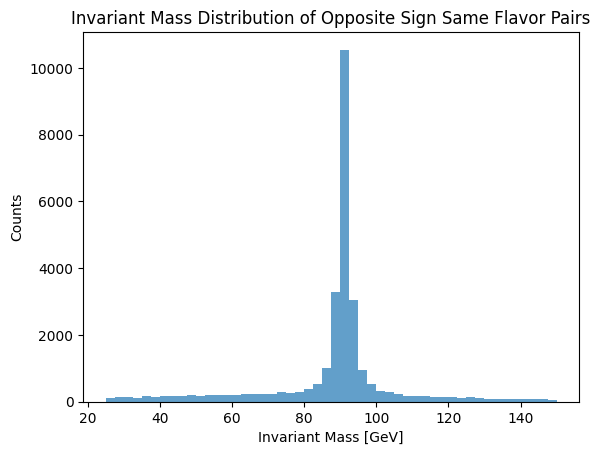

In [10]:
# opposite sign same flavor pairs
mu_pairs = ak.combinations(muons, 2, fields=["mu1", "mu2"])
os_sf_pairs = mu_pairs[(mu_pairs.mu1.charge + mu_pairs.mu2.charge) == 0]

ele_pairs = ak.combinations(electrons, 2, fields=["e1", "e2"])
os_sf_ele_pairs = ele_pairs[(ele_pairs.e1.charge + ele_pairs.e2.charge) == 0]

# invariant mass of pairs
def invariant_mass(p1, p2):
	# p1 and p2 are Momentum4D awkward records
	E = p1.mass * 0  # dummy to get shape
	E = p1.pt * np.cosh(p1.eta) + p2.pt * np.cosh(p2.eta)
	px = p1.pt * np.cos(p1.phi) + p2.pt * np.cos(p2.phi)
	py = p1.pt * np.sin(p1.phi) + p2.pt * np.sin(p2.phi)
	pz = p1.pt * np.sinh(p1.eta) + p2.pt * np.sinh(p2.eta)
	mass = np.sqrt(np.maximum(0, (E)**2 - (px)**2 - (py)**2 - (pz)**2))
	return mass

mu_mass = invariant_mass(os_sf_pairs.mu1, os_sf_pairs.mu2)
ele_mass = invariant_mass(os_sf_ele_pairs.e1, os_sf_ele_pairs.e2)

z_mass = ak.flatten(ak.concatenate([mu_mass, ele_mass], axis=1))

#plot invariant mass distribution
plt.hist(z_mass, bins=50, range=(25, 150), alpha=0.7)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Invariant Mass Distribution of Opposite Sign Same Flavor Pairs")
plt.show()

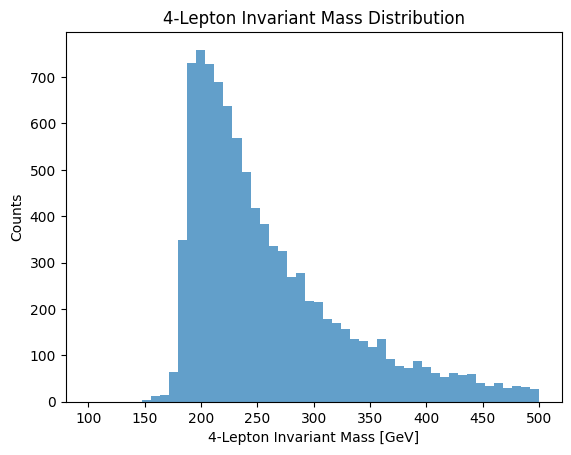

In [11]:
# 4 lepton invariant mass
leptons = ak.concatenate([muons, electrons], axis=1)
four_leptons = leptons[ak.num(leptons) == 4]

# compute px, py, pz, E for each lepton
px = four_leptons.pt * np.cos(four_leptons.phi)
py = four_leptons.pt * np.sin(four_leptons.phi)
pz = four_leptons.pt * np.sinh(four_leptons.eta)
E  = four_leptons.pt * np.cosh(four_leptons.eta)  # massless approx

# sum four-vectors for each event
px_sum = ak.sum(px, axis=1)
py_sum = ak.sum(py, axis=1)
pz_sum = ak.sum(pz, axis=1)
E_sum  = ak.sum(E, axis=1)

four_lepton_mass = np.sqrt(np.maximum(0, E_sum**2 - px_sum**2 - py_sum**2 - pz_sum**2))

# plot 4 lepton invariant mass distribution
plt.hist(ak.ravel(four_lepton_mass), bins=50, range=(100, 500), alpha=0.7)
plt.xlabel("4-Lepton Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("4-Lepton Invariant Mass Distribution")
plt.show()

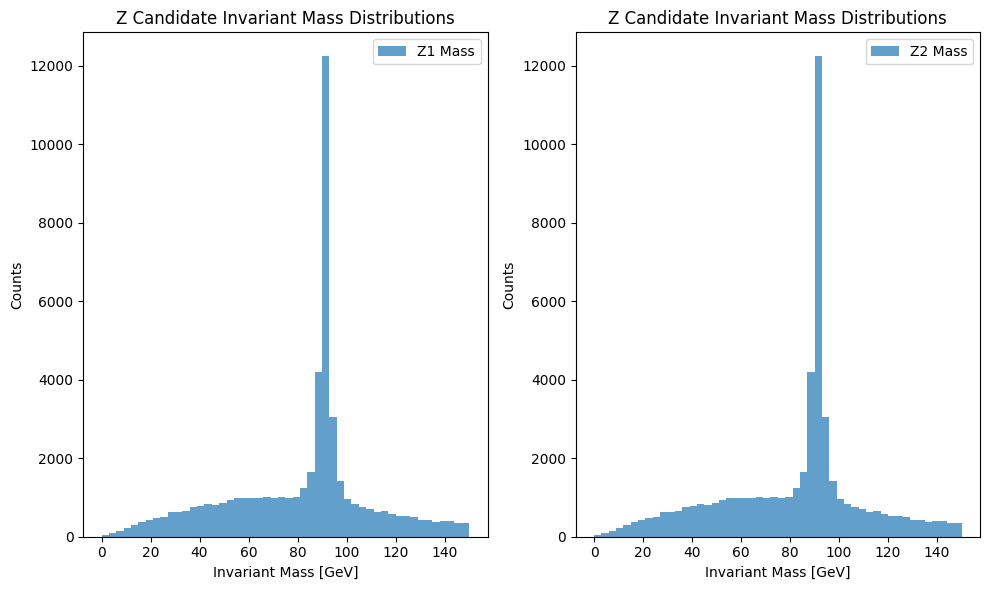

In [16]:
#invariant mass of pairs
z_pairss = ak.combinations(four_leptons, 2, fields=["l1", "l2"])
z1 = invariant_mass(z_pairss.l1, z_pairss.l2)
z2 = invariant_mass(z_pairss.l2, z_pairss.l1)

#masses of the Z candidates
z1_masss = ak.flatten(z1)
z2_masss = ak.flatten(z2)

#plot Z candidate mass distributions
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(z1_masss, bins=50, range=(0, 150), alpha=0.7, label="Z1 Mass")
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Z Candidate Invariant Mass Distributions")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(z2_masss, bins=50, range=(0, 150), alpha=0.7, label="Z2 Mass")
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Z Candidate Invariant Mass Distributions")
plt.legend()
plt.tight_layout()
plt.show()

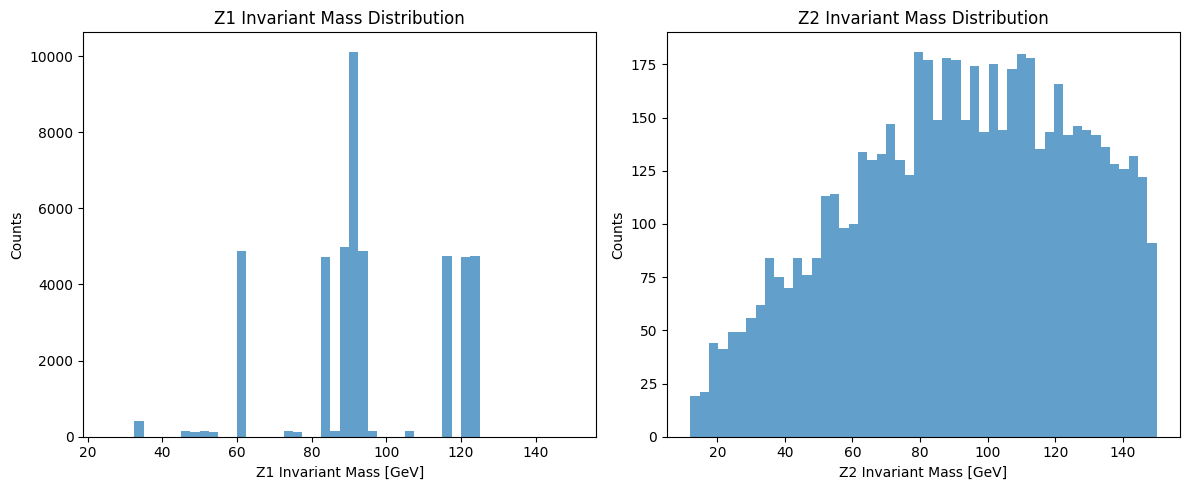

In [14]:
# z pairs from 4 leptons
z_pairs = ak.combinations(four_leptons, 2, fields=["lep1", "lep2"])

# build four-vector components for each lepton in each pair (use massful energy)
lep1 = z_pairs.lep1
lep2 = z_pairs.lep2

px1 = lep1.pt * np.cos(lep1.phi)
py1 = lep1.pt * np.sin(lep1.phi)
pz1 = lep1.pt * np.sinh(lep1.eta)
E1  = np.sqrt(px1**2 + py1**2 + pz1**2 + lep1.mass**2)

px2 = lep2.pt * np.cos(lep2.phi)
py2 = lep2.pt * np.sin(lep2.phi)
pz2 = lep2.pt * np.sinh(lep2.eta)
E2  = np.sqrt(px2**2 + py2**2 + pz2**2 + lep2.mass**2)

# sum to get Z1 four-vector per pair
z1_px = px1 + px2
z1_py = py1 + py2
z1_pz = pz1 + pz2
z1_E  = E1 + E2

z1_mass = np.sqrt(np.maximum(0, z1_E**2 - z1_px**2 - z1_py**2 - z1_pz**2))

# pack z1 as a record so later indexing works similarly to original code
z1 = ak.zip({
	"px": z1_px,
	"py": z1_py,
	"pz": z1_pz,
	"E": z1_E,
	"mass": z1_mass
})

# choose the candidate pair per event whose mass is closest to the Z mass
z1_close = ak.argmin(abs(z1_mass - 91.1876), axis=1)
z1_candidates = z1[z1_close]

# compute the Z2 four-vector as the remainder of the event four-vector minus Z1
# use precomputed event sums px_sum, py_sum, pz_sum, E_sum (from earlier cells)
z2_px = px_sum - z1_candidates.px
z2_py = py_sum - z1_candidates.py
z2_pz = pz_sum - z1_candidates.pz
z2_E  = E_sum  - z1_candidates.E

z2_mass = np.sqrt(np.maximum(0, z2_E**2 - z2_px**2 - z2_py**2 - z2_pz**2))

# now z1_candidates.mass and z2_mass are available for plotting
z1_mass = z1_candidates.mass

# plot z1 and z2 mass distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(ak.ravel(z1_mass), bins=50, range=(25, 150), alpha=0.7)
plt.xlabel("Z1 Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Z1 Invariant Mass Distribution")

plt.subplot(1, 2, 2)
plt.hist(ak.ravel(z2_mass), bins=50, range=(12, 150), alpha=0.7)
plt.xlabel("Z2 Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Z2 Invariant Mass Distribution")

plt.tight_layout()
plt.show()

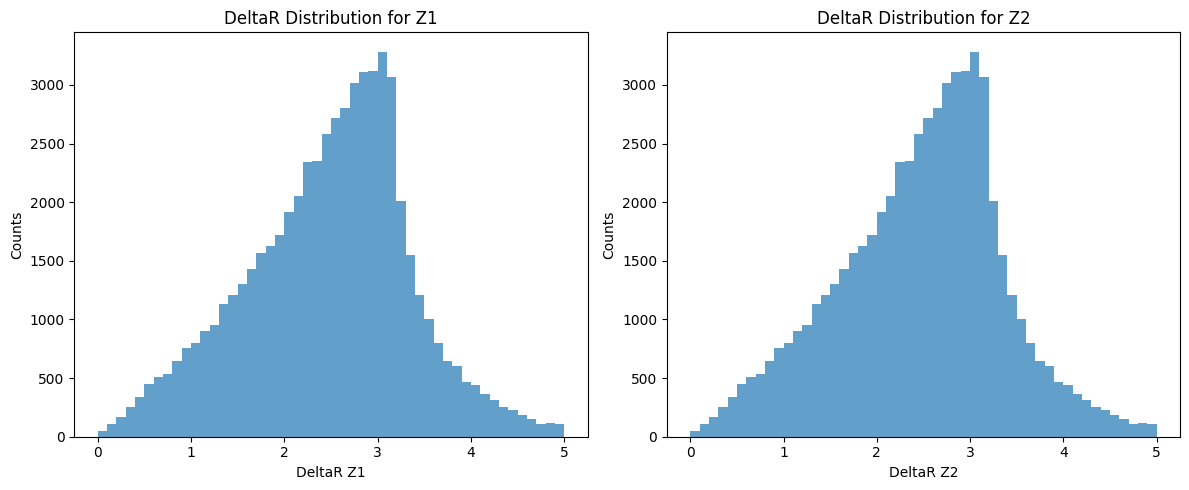

In [17]:
#compute deltaR between leptons in z1 and z2
deta = z_pairs.lep1.eta - z_pairs.lep2.eta
dphi_i = z_pairs.lep1.phi - z_pairs.lep2.phi
dphi = (dphi_i + np.pi) % (2 * np.pi) - np.pi  # wrap-around
deltaR_z1 = np.sqrt(deta**2 + dphi**2)
deltaR_z2 = np.sqrt(deta**2 + dphi**2)

#plot deltaR distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(ak.ravel(deltaR_z1), bins=50, range=(0, 5), alpha=0.7)
plt.xlabel("DeltaR Z1")
plt.ylabel("Counts")
plt.title("DeltaR Distribution for Z1")
plt.subplot(1, 2, 2)
plt.hist(ak.ravel(deltaR_z2), bins=50, range=(0, 5), alpha=0.7)
plt.xlabel("DeltaR Z2")
plt.ylabel("Counts")
plt.title("DeltaR Distribution for Z2")
plt.tight_layout()
plt.show()

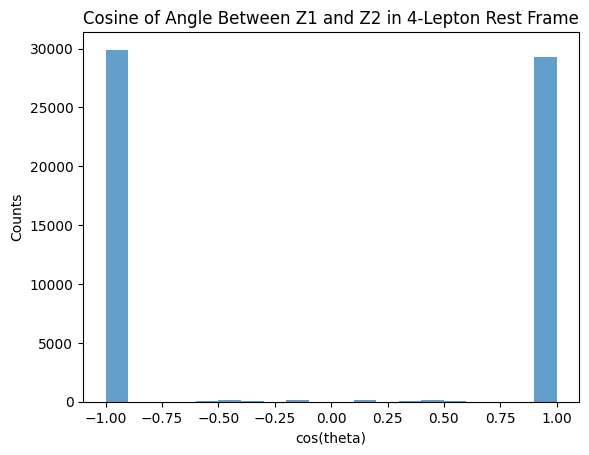

In [19]:
# cosine of angle between z1 and z2 in 4-lepton rest frame
# use the event-level summed four-vector computed earlier (px_sum, py_sum, pz_sum, E_sum)
four_lepton_px = px_sum
four_lepton_py = py_sum
four_lepton_pz = pz_sum
four_lepton_E  = E_sum

# compute beta components (velocity = p / E); guard against divide-by-zero
beta_x = -four_lepton_px / four_lepton_E
beta_y = -four_lepton_py / four_lepton_E
beta_z = -four_lepton_pz / four_lepton_E

beta_mag = np.sqrt(beta_x**2 + beta_y**2 + beta_z**2)
# avoid zero magnitude
beta_mag = ak.where(beta_mag == 0, 1e-12, beta_mag)

# projection of Z1 momentum onto beta direction, normalized to get cosine
costheta = (z1_candidates.px * beta_x + z1_candidates.py * beta_y + z1_candidates.pz * beta_z) / (z1_candidates.mass * beta_mag)

# clip numerical noise to [-1, 1]
costheta = ak.where(costheta > 1, 1, ak.where(costheta < -1, -1, costheta))

# plot costheta distribution
plt.hist(ak.ravel(costheta), bins=20, range=(-1, 1), alpha=0.7)
plt.xlabel("cos(theta)")
plt.ylabel("Counts")
plt.title("Cosine of Angle Between Z1 and Z2 in 4-Lepton Rest Frame")
plt.show()

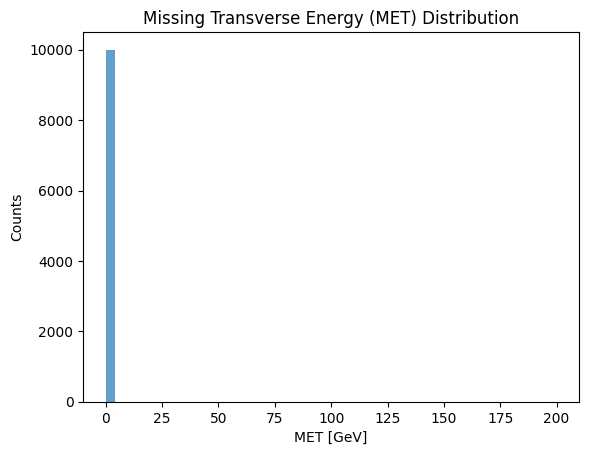

In [ ]:
#MET checks
plt.hist(ak.to_numpy(met_pt[ak.num(leptons) == 4]), bins=50, range=(0, 200), alpha=0.7)
plt.xlabel("MET [GeV]")
plt.ylabel("Counts")
plt.title("Missing Transverse Energy (MET) Distribution")
plt.show()

In [ ]:
#estimate cross-section

N_events = tree2.num_entries
gen_pb = 0.04225 +- 0.0001078 #MadGraph's reported cross-section for pp->ZZ->4l at 13 TeV
luminosity = N_events / gen_pb  # in pb^-1

print(f"Estimated Luminosity: {luminosity} pb^-1")

#z z selection
N_z_selection = ak.sum((z1_mass > 60) & (z1_mass < 120) & (z2_mass > 60) & (z2_mass < 120))
print(f"Number of events passing Z selection: {N_z_selection}")

efficiency = N_z_selection / N_events
print(f"Selection Efficiency: {efficiency}")

#effective cross-section for selected events
selected_cs = N_z_selection / luminosity
print(f"Effective Cross-Section after Z selection: {selected_cs} pb")



Estimated Luminosity: 237291.8357370996 pb^-1
Number of events passing Z selection: 20288
Selection Efficiency: 2.0288
Effective Cross-Section after Z selection: 0.08549809536000001 pb
